In [93]:
!pip install git+https://github.com/facebookresearch/esm.git -q

In [1]:
import numpy as np
import pandas as pd
import torch
import esm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas()
import gc

ModuleNotFoundError: No module named 'esm'

In [2]:
!pip install -Uqq fastbook

In [3]:
from fastbook import *

In [4]:
df = pd.read_csv('df_combine.csv')
test_df = pd.read_csv('test_combine.csv')

## Seed

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## Get esm feature

In [95]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [96]:
if torch.cuda.is_available():
    model = model.cuda()
    print("Transferred model to GPU")

Transferred model to GPU


In [97]:
def get_feature(r,colname):
    data = [('protein',r[colname])]
    labels, strs, tokens = batch_converter(data)
    with torch.no_grad(): 
        results = model(tokens.cuda(), repr_layers=[33], return_contacts=True)
    rpr = results["representations"][33].squeeze()
    rpr=rpr[1 : len(r[colname]) + 1].mean(0).detach().cpu().numpy()
    
    del results, labels, strs, tokens, data #especially need to delete those on cuda: tokens, results

    return rpr

In [98]:
def get_feature_df(df,colname):
    series = df.progress_apply(lambda r: get_feature(r,colname), axis=1)
    df_feature = pd.DataFrame(series.tolist())
    return df_feature

### In order to process esm, delete long sequence

In [9]:
df['len'] = df.mut_seq.apply(len)

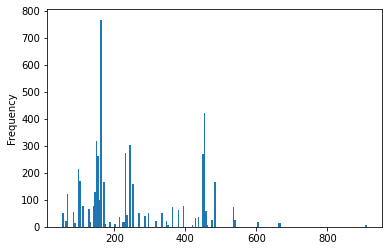

In [10]:
df.query('len < 1000').len.plot.hist(bins=200);

In [11]:
df = df.query('len < 800')

In [42]:
mut_feature = get_feature_df(df,'mut_seq')
wt_feature = get_feature_df(df,'wt_seq')

  0%|          | 0/5139 [00:00<?, ?it/s]

  0%|          | 0/5139 [00:00<?, ?it/s]

In [90]:
test = pd.read_csv('test_sub.csv')

In [99]:
test_mut = get_feature_df(test,'mut_seq')
test_wt = get_feature_df(test,'wt_seq')

  0%|          | 0/2413 [00:00<?, ?it/s]

  0%|          | 0/2413 [00:00<?, ?it/s]

In [101]:
test_combine.mut_seq.transform(len)

0       221
1       221
2       220
3       221
4       221
       ... 
2408    221
2409    221
2410    221
2411    221
2412    221
Name: mut_seq, Length: 2413, dtype: int64

In [110]:
test_feature = test_wt - test_mut
test_combine = pd.concat([test, test_feature],axis=1)
test_combine['len'] = test_combine.mut_seq.transform(len)
test_combine.to_csv('test_combine.csv')

In [113]:
test_combine.rename(columns={'pH':'pH2'},inplace=True)

In [146]:
test_df=test_combine.copy()

In [157]:
test_df.to_csv('test_combine.csv',index=False)

In [1]:
test_df = pd.read_csv('test_combine.csv')

NameError: name 'pd' is not defined

### Get feature differences

In [43]:
diff_feature = wt_feature - mut_feature

In [54]:
df.reset_index(inplace=True) #make sure the index of two concat dfs are same
df_combine = pd.concat([df, diff_feature], axis=1)

In [5]:
df_combine = pd.read_csv('with_esm_feature.csv')

## Filter out data with dTm

In [6]:
df_combine = df_combine.dropna(subset = 'Tm')

## Fill pH NaN

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
df_combine['pH2'] = df_combine.groupby('group').pH.transform(lambda x: x.fillna(x.mean()))

### for those groups that don't have pH or pH.mean() at all, fill with 8

In [9]:
df_combine.pH2.fillna(8, inplace=True)

In [10]:
df_combine.pH2.isna().sum()

0

## Normalize Targets

In [11]:
df_combine['y_max'] = df_combine.groupby('group').Tm.transform(lambda x: x/x.max())

In [12]:
df_combine['y_normalize'] = df_combine.groupby('group').Tm.transform(lambda x: (x-x.mean())/x.std() )

In [13]:
df_combine.y_max.isna().sum(),df_combine.y_normalize.isna().sum()

(0, 52)

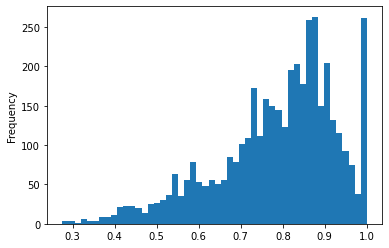

In [16]:
df_combine.y_max.plot.hist(bins=50);

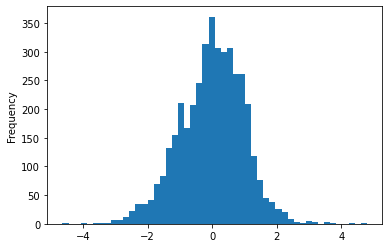

In [17]:
df_combine.y_normalize.plot.hist(bins=50);

### Interestingly, there are some groups with same Tm all the time (std=0), so filter out

In [18]:
df_combine[df_combine.groupby('group').Tm.transform(lambda x: x.std()==0)].group.unique()

array([37, 66, 68, 69])

In [19]:
df_combine[df_combine.y_normalize.isna()].group.unique()

array([37, 66, 68, 69])

In [20]:
df_combine = df_combine.dropna(subset='y_normalize')

In [21]:
37 in df_combine.group.to_list()

False

In [22]:
df_combine.shape

(4108, 1292)

In [116]:
df = df[df.group!=33]

## Check how many per group; remove group count < 20

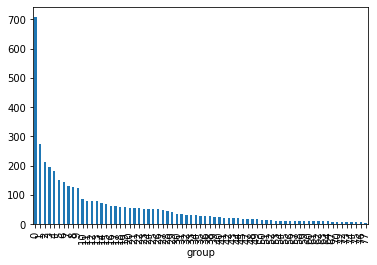

In [23]:
df_combine.groupby('group').mut_seq.count().plot.bar();

In [24]:
df_combine = df_combine[df_combine.groupby('group').mut_seq.transform(lambda x: x.count()>=20)]

### check the distribution of y_normalize after filter

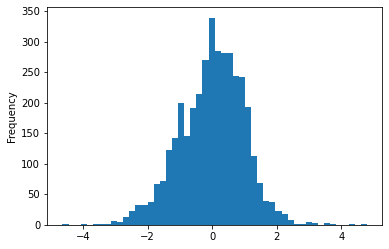

In [25]:
df_combine.y_normalize.plot.hist(bins=50);

In [117]:
df.reset_index(drop=True, inplace=True)

In [118]:
df.to_csv('df_combine.csv', index=False)

In [119]:
df = pd.read_csv('df_combine.csv')


## Define feature columns

In [12]:
esm_feature = [str(i) for i in range(1280)]

In [13]:
others = ['pH2','len']

In [14]:
features = esm_feature + others

## Make Dataset

In [15]:
from torch.utils.data import Dataset

In [16]:
class MyDataset(Dataset):
    def __init__(self,df, features,target):
        self.df = df
        self.x = df.loc[:,features].values*1000
        self.y = df.loc[:,target].values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        feature = torch.as_tensor(self.x[idx],dtype=torch.float32)
        label = torch.as_tensor(self.y[idx],dtype=torch.float32)
        return feature,label

In [17]:
class TestDataset(Dataset):
    def __init__(self,df, features):
        self.df = df
        self.x = df.loc[:,features].values*1000
        # self.y = df.loc[:,target].values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        feature = torch.as_tensor(self.x[idx],dtype=torch.float32)
        # label = torch.as_tensor(self.y[idx],dtype=torch.float32)
        return feature

In [18]:
dataset = MyDataset(df,features,'y_normalize')

In [19]:
dataset[3]

(tensor([ 2.2642e+00, -2.7809e+00,  2.9928e+00,  ..., -1.4168e+00,  6.5000e+03,  1.6400e+05]),
 tensor(0.9831))

### DataLoader

In [20]:
dl = DataLoader(dataset,bs=8,shuffle=True,num_workers=4)

In [21]:
x, y = dl.one_batch()

## Model

In [18]:
model1 = nn.Sequential(nn.LazyLinear(500),
                      nn.LazyBatchNorm1d(),
                      nn.LazyLinear(200),
                      nn.LazyBatchNorm1d(), 
                      nn.LazyLinear(1))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
class Model2(Module):
    def __init__(self, num_features, num_targets, hidden_size):
        cha_1 = 256
        cha_2 = 512
        cha_3 = 512

        cha_1_reshape = int(hidden_size/cha_1)
        cha_po_1 = int(hidden_size/cha_1/2)
        cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3

        self.cha_1 = cha_1
        self.cha_2 = cha_2
        self.cha_3 = cha_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

        self.batch_norm_c1 = nn.BatchNorm1d(cha_1)
        self.dropout_c1 = nn.Dropout(0.1)
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(cha_1,cha_2, kernel_size = 5, stride = 1, padding=2,  bias=False),dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

        self.batch_norm_c2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2 = nn.Dropout(0.1)
        self.conv2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_1 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_1 = nn.Dropout(0.3)
        self.conv2_1 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

        self.batch_norm_c2_2 = nn.BatchNorm1d(cha_2)
        self.dropout_c2_2 = nn.Dropout(0.2)
        self.conv2_2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_3, kernel_size = 5, stride = 1, padding=2, bias=True),dim=None)

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
        self.dropout3 = nn.Dropout(0.2)
        self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

    def forward(self, x):

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.dense1(x), alpha=0.06)

        x = x.reshape(x.shape[0],self.cha_1,
                      self.cha_1_reshape)

        x = self.batch_norm_c1(x)
        x = self.dropout_c1(x)
        x = F.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = F.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c2_1(x)
        x = self.dropout_c2_1(x)
        x = F.relu(self.conv2_1(x))

        x = self.batch_norm_c2_2(x)
        x = self.dropout_c2_2(x)
        x = F.relu(self.conv2_2(x))
        x =  x * x_s

        x = self.max_po_c2(x)

        x = self.flt(x)

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)

        return x

In [23]:
num_features = x.shape[1]
num_targets=1
hidden_size=4096

In [35]:
x = x.to(device)

In [34]:
model = model.to(device)

In [24]:
model = Model2(num_features,num_targets,hidden_size)

In [36]:
pred = model(x)

In [27]:
pred

tensor([[-0.9853],
        [ 0.8692],
        [ 0.8756],
        [-0.0468],
        [-0.3934],
        [-0.2871],
        [ 0.4067],
        [ 0.3020]], grad_fn=<AddmmBackward0>)

## Loss

In [28]:
loss_fn = MSELossFlat()

In [29]:
loss_fn(pred, y)

TensorBase(0.6101, grad_fn=<AliasBackward0>)

## Prepare training

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
# learn = Learner(dl,model,loss_func=MSELossFlat())

In [32]:
model = model2.cuda()

### Optimizer

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

### Scheduler

In [43]:
from torch.optim.lr_scheduler import OneCycleLR

In [35]:
scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(dl),div_factor=1e3, epochs=25,pct_start=0.1)

## Training OLOS

In [37]:
def train_fn(dl,model,loss_fn, optimizer,scheduler):
    
    model.train()
    final_loss=0
    
    for x, y in dl:
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dl)
    
    return final_loss

In [38]:
def valid_fn(dl,model,loss_fn):
    model.eval()
    final_loss = 0
    preds = []
    with torch.no_grad():
        for x,y in dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            final_loss += loss.item()
            preds.append(pred.detach().cpu().numpy())
        
    final_loss /= len(dl)
    preds = np.concatenate(preds)
    
    return final_loss, preds

In [39]:
def test_fn(dl,model):
    model.eval()
    preds = []
    with torch.no_grad():
        for x in dl:
            x = x.to(device)
            pred = model(x)
            preds.append(pred.detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

### GroupKFold

In [40]:
from sklearn.model_selection import GroupKFold

In [41]:
from scipy import stats

In [43]:
model = Model2(num_features,num_targets,hidden_size)

In [46]:
model.to(device)

Model2(
  (batch_norm1): BatchNorm1d(1282, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=1282, out_features=4096, bias=True)
  (batch_norm_c1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c1): Dropout(p=0.1, inplace=False)
  (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (ave_po_c1): AdaptiveAvgPool1d(output_size=8)
  (batch_norm_c2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c2): Dropout(p=0.1, inplace=False)
  (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm_c2_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c2_1): Dropout(p=0.3, inplace=False)
  (conv2_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm_c2_2): BatchNorm1d(512, eps=1e-05, momentum=0

In [48]:
model.train()
final_loss=0

for x, y in train_dl:
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    final_loss += loss.item()

final_loss /= len(dl)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1282])

In [49]:
train_dl = DataLoader(train_ds,bs=8,shuffle=True,num_workers=4,drop_last=True)

In [50]:
train_fn(train_dl,model,loss_fn, optimizer,scheduler)

0.8554554958647924

In [45]:
seed_everything(2)

test_preds = np.zeros((len(test_df), 1))
oofs = np.zeros((len(df), 1))

for fold, (train_idx, valid_idx) in enumerate(GroupKFold(2).split(df, groups=df.group)):
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]

    train_ds = MyDataset(train_df,features,'y_normalize')
    valid_ds = MyDataset(valid_df,features,'y_normalize')

    train_dl = DataLoader(train_ds,bs=8,shuffle=True,num_workers=4,drop_last=True)
    valid_dl = DataLoader(valid_ds,bs=8,shuffle=False,num_workers=4)

    oof = np.zeros((len(df), 1))
    best_loss = np.inf

    model = Model2(num_features,num_targets,hidden_size).cuda()
    loss_fn = MSELossFlat()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(train_dl),div_factor=1e3, epochs=25,pct_start=0.1)

    for epoch in range(10):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train_fn(train_dl,model,loss_fn, optimizer,scheduler)
        valid_loss,valid_preds = valid_fn(valid_dl,model,loss_fn)
        # spearman = stats.spearmanr(valid_preds, valid_ds.y)
        print(f'In fold{fold} epoch{epoch}, train loss:{train_loss}, valid loss:{valid_loss},spearman:{spearman}')

        if valid_loss < best_loss:
            best_loss = valid_loss
            oof[valid_idx] = valid_preds
            torch.save(model.state_dict(),f'my_model/fold{fold}.pth')


    test_ds = TestDataset(test_df,features)
    test_dl = DataLoader(test_ds,bs=8,shuffle=False,num_workers=4)

    model = Model2(num_features,num_targets,hidden_size)
    model.load_state_dict(torch.load(f'my_model/fold{fold}.pth'))
    model.to(device)

    oofs+=oof/2

    test_preds += test_fn(test_dl,model)/2

Epoch 1
-------------------------------


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1282])

In [144]:
df.loc[:,features]

0         1         2         3         4         5         6  \
0     0.002264 -0.002781  0.002993  0.000917 -0.002048 -0.000943 -0.001373   
1     0.002264 -0.002781  0.002993  0.000917 -0.002048 -0.000943 -0.001373   
2     0.002264 -0.002781  0.002993  0.000917 -0.002048 -0.000943 -0.001373   
3     0.002264 -0.002781  0.002993  0.000917 -0.002048 -0.000943 -0.001373   
4     0.003853 -0.001638  0.002186  0.000431 -0.000128 -0.004285  0.000982   
...        ...       ...       ...       ...       ...       ...       ...   
3728 -0.006661  0.008035 -0.009155 -0.002379  0.012057  0.001170 -0.010383   
3729 -0.002724  0.007787 -0.007066 -0.002400  0.009299  0.002487 -0.013997   
3730 -0.013817  0.029486  0.004163 -0.006857 -0.003146 -0.006858 -0.005760   
3731 -0.007250  0.010681  0.001937  0.001830 -0.000256  0.003161 -0.014018   
3732 -0.016595  0.008654  0.009148 -0.005493 -0.001894  0.002628 -0.014169   

             7         8         9        10        11        12        13  \
0     0.003532 -0.001310  0.000956  0.000494  0.001978  0.002956 -0.001324   
1     0.003532 -0.001310  0.000956  0.000494  0.001978  0.002956 -0.001324   
2     0.003532 -0.001310  0.000956  0.000494  0.001978  0.002956 -0.001324   
3     0.003532 -0.001310  0.000956  0.000494  0.001978  0.002956 -0.001324   
4     0.001414 -0.002309 -0.001756 -0.000616 -0.001022  0.004372  0.002630   
...        ...       ...       ...       ...       ...       ...       ...   
3728 -0.014578 -0.000262 -0.001369 -0.000100 -0.003785  0.011649  0.010520   
3729 -0.010191  0.002911 -0.002189  0.001210 -0.001323  0.014294  0.010910   
3730 -0.020783 -0.013606 -0.005511  0.004536  0.002366 -0.011819  0.009227   
3731 -0.017502 -0.000072 -0.000415  0.002674 -0.004436 -0.001075  0.008390   
3732 -0.014779 -0.007168 -0.001789  0.006362  0.000314 -0.003315  0.006398   

            14        15        16        17        18        19        20  \
0     0.000159 -0.004518  0.001749 -0.000429  0.000160 -0.002305 -0.001531   
1     0.000159 -0.004518  0.001749 -0.000429  0.000160 -0.002305 -0.001531   
2     0.000159 -0.004518  0.001749 -0.000429  0.000160 -0.002305 -0.001531   
3     0.000159 -0.004518  0.001749 -0.000429  0.000160 -0.002305 -0.001531   
4     0.001775 -0.004346  0.004295  0.001574  0.001650 -0.000780  0.004574   
...        ...       ...       ...       ...       ...       ...       ...   
3728 -0.002360  0.008861 -0.008410 -0.005508  0.004878  0.000146  0.000909   
3729  0.000119  0.015777 -0.005181 -0.001773  0.003858  0.005053  0.004114   
3730  0.000824 -0.009165  0.005680  0.002049 -0.004772  0.009497 -0.001135   
3731  0.000579  0.000157  0.007658 -0.003908 -0.004524  0.007933  0.001242   
3732 -0.006350 -0.007348  0.011564  0.001449 -0.002290  0.012800  0.000849   

            21        22        23        24        25        26        27  \
0    -0.003535  0.000692  0.004050 -0.001401 -0.002957 -0.001412 -0.002671   
1    -0.003535  0.000692  0.004050 -0.001401 -0.002957 -0.001412 -0.002671   
2    -0.003535  0.000692  0.004050 -0.001401 -0.002957 -0.001412 -0.002671   
3    -0.003535  0.000692  0.004050 -0.001401 -0.002957 -0.001412 -0.002671   
4     0.000564 -0.000518 -0.000238 -0.004106 -0.001015 -0.002564 -0.000180   
...        ...       ...       ...       ...       ...       ...       ...   
3728 -0.010197  0.005627 -0.003347 -0.008280  0.005344 -0.001989  0.010492   
3729 -0.004690  0.004562  0.005725 -0.003837  0.004453  0.000589  0.011127   
3730  0.002838 -0.005431  0.017724 -0.018711  0.004037 -0.002446  0.013329   
3731  0.005038 -0.006273  0.007947 -0.004193 -0.001508  0.004787  0.006453   
3732  0.013553 -0.019136  0.010726 -0.005807  0.005303  0.010414  0.016278   

            28        29        30        31        32        33        34  \
0    -0.005783 -0.001800  0.000789  0.000644 -0.001406  0.002964  0.002923   
1    -0.005783 -0.001800  0.000789  0.000644 -0.001406  0.002964  0.002923   
2    -0.005783 -0.001800  0.000

In [51]:
def run_kfold(Nfolds, seed):
    
    seed_everything(seed)
    
    test_preds = np.zeros((len(test_df), 1))
    oofs = np.zeros((len(df), 1))
    
    for fold, (train_idx, valid_idx) in enumerate(GroupKFold(Nfolds).split(df, groups=df.group)):
        train_df = df.iloc[train_idx]
        valid_df = df.iloc[valid_idx]

        train_ds = MyDataset(train_df,features,'y_normalize')
        valid_ds = MyDataset(valid_df,features,'y_normalize')

        train_dl = DataLoader(train_ds,bs=8,shuffle=True,num_workers=4,drop_last=True)
        valid_dl = DataLoader(valid_ds,bs=8,shuffle=False,num_workers=4)

        oof = np.zeros((len(df), 1))
        best_loss = np.inf
        
        model = Model2(num_features,num_targets,hidden_size).cuda()
        loss_fn = MSELossFlat()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = OneCycleLR(optimizer, max_lr=1e-2,steps_per_epoch=len(train_dl),div_factor=1e3, epochs=25,pct_start=0.1)

        for epoch in range(10):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_loss = train_fn(train_dl,model,loss_fn, optimizer,scheduler)
            valid_loss,valid_preds = valid_fn(valid_dl,model,loss_fn)
            spearman = stats.spearmanr(valid_preds, valid_ds.y)
            print(f'In fold{fold} epoch{epoch}, train loss:{train_loss}, valid loss:{valid_loss},spearman:{spearman}')

            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[valid_idx] = valid_preds
                torch.save(model.state_dict(),f'my_model/fold{fold}.pth')


        test_ds = TestDataset(test_df,features)
        test_dl = DataLoader(test_ds,bs=8,shuffle=False,num_workers=4)

        model = Model2(num_features,num_targets,hidden_size)
        model.load_state_dict(torch.load(f'my_model/fold{fold}.pth'))
        model.to(device)

        oofs+=oof/Nfolds

        test_preds += test_fn(test_dl,model)/Nfolds
        
    

    return test_preds, oofs
    

In [52]:
SEED = [0]

oof = np.zeros((len(df), 1))
test_preds = np.zeros((len(test_df), 1))

for seed in SEED:
    test_preds_, oof_ = run_kfold(2,seed)
    test_preds+=test_preds_/len(SEED)
    oof+=oof_/len(SEED)
    
df['oof'] = oof
test_df['preds'] = test_preds

Epoch 1
-------------------------------
In fold0 epoch0, train loss:1.434931073321805, valid loss:14.619668229841269,spearman:SpearmanrResult(correlation=0.11455116312215358, pvalue=6.906415707203958e-07)
Epoch 2
-------------------------------
In fold0 epoch1, train loss:1.024717537694223, valid loss:1.4275647434206982,spearman:SpearmanrResult(correlation=0.10978929843477474, pvalue=1.9713279845225363e-06)
Epoch 3
-------------------------------
In fold0 epoch2, train loss:0.9458545974012097, valid loss:1.0320116445963454,spearman:SpearmanrResult(correlation=0.14043892547684603, pvalue=1.087603060461803e-09)
Epoch 4
-------------------------------
In fold0 epoch3, train loss:0.8924413874041881, valid loss:1.0060919251722784,spearman:SpearmanrResult(correlation=0.14356329892362316, pvalue=4.5753399569586035e-10)
Epoch 5
-------------------------------
In fold0 epoch4, train loss:0.8758156613282891, valid loss:1.208500983320877,spearman:SpearmanrResult(correlation=0.2277883425947571, pv

In [ ]:
stats.spearmanr(valid_preds, valid_ds.y)

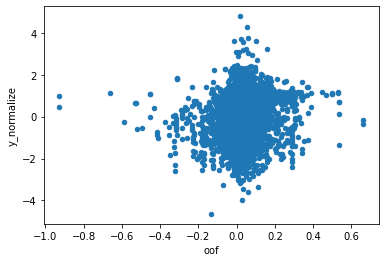

In [53]:
df.plot.scatter(x='oof',y='y_normalize');

In [54]:
df.groupby('group')[['oof','y_normalize']].apply(lambda x: x.corr('spearman').oof.y_normalize)

group
0     0.073685
1     0.271525
2     0.162579
3     0.310813
4     0.207076
5     0.178303
6     0.139770
7     0.224328
8     0.009251
9     0.251276
10    0.062934
11    0.315801
12    0.431585
13    0.388309
14    0.299967
15   -0.163214
16   -0.012990
17    0.170564
18    0.324426
19    0.571364
20    0.076772
21    0.313968
22    0.497625
23   -0.136987
24    0.295745
25    0.441062
26    0.107100
27    0.277696
28    0.507661
29    0.539755
30    0.321945
31   -0.148490
32    0.191930
34    0.177243
35    0.463575
36    0.007946
38    0.452398
39    0.173144
40    0.039131
41    0.273554
dtype: float64

In [77]:
df[['oof','y_normalize']].corr('spearman')

,oof,y_normalize
oof,1.000000,0.038054
y_normalize,0.038054,1.000000


In [162]:
test_preds

array([[0.47156996],
       [0.53584355],
       [0.5202725 ],
       ...,
       [0.5280656 ],
       [0.5192892 ],
       [0.6572173 ]], dtype=float32)

In [94]:
model.cuda()

Sequential(
  (0): Linear(in_features=1282, out_features=500, bias=True)
  (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=200, out_features=1, bias=True)
)

In [95]:
for epoch in range(5):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(dl)
    test(dl)

Epoch 1
-------------------------------
loss: 1.080293  [    0/ 3764]
loss: 1.687482  [  800/ 3764]
loss: 1.118925  [ 1600/ 3764]
loss: 0.757889  [ 2400/ 3764]
loss: 0.668643  [ 3200/ 3764]
Test Error: Avg loss: 0.945010
Epoch 2
-------------------------------
loss: 0.988457  [    0/ 3764]
loss: 0.538472  [  800/ 3764]
loss: 1.003537  [ 1600/ 3764]
loss: 0.696454  [ 2400/ 3764]
loss: 0.936770  [ 3200/ 3764]
Test Error: Avg loss: 0.940664
Epoch 3
-------------------------------
loss: 0.864447  [    0/ 3764]
loss: 0.333849  [  800/ 3764]
loss: 0.419051  [ 1600/ 3764]
loss: 1.874793  [ 2400/ 3764]
loss: 0.546775  [ 3200/ 3764]
Test Error: Avg loss: 0.917771
Epoch 4
-------------------------------
loss: 0.171663  [    0/ 3764]
loss: 0.947445  [  800/ 3764]
loss: 1.595440  [ 1600/ 3764]
loss: 0.756516  [ 2400/ 3764]
loss: 0.356026  [ 3200/ 3764]
Test Error: Avg loss: 0.940091
Epoch 5
-------------------------------
loss: 1.478294  [    0/ 3764]
loss: 0.909177  [  800/ 3764]
loss: 0.459987  

In [57]:
df_combine.to_csv('with_esm_feature.csv', index=False)

In [57]:
gc.collect();torch.cuda.empty_cache()

# Get WT feature

In [89]:
df_wt = pd.DataFrame(df2.wildtype.unique())

In [94]:
df_wt.rename(columns={0: 'protein_sequence'},inplace=True)

In [95]:
wt_feature = get_feature_df(df_wt)

  0%|          | 0/78 [00:00<?, ?it/s]

In [99]:
wt_combine = pd.concat([df_wt, wt_feature], axis=1)

In [102]:
wt_combine.to_csv('wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [112]:
wt_combine.head()

,protein_sequence,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,MEELQDDYEDMMEENLEQEEYEDPDIPESQMEEPAAHDTEATATDY...,-0.017728,0.002291,-0.005282,-0.005080,-0.027136,-0.036133,0.065131,0.004717,0.007467,...,0.056245,0.033457,-0.124666,-0.020386,0.027567,-0.074638,0.048811,-0.047698,0.007801,0.049899
2,MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPANQ...,0.016938,0.050288,0.001779,-0.010340,-0.100914,0.016280,0.007097,-0.068371,0.050936,...,0.037742,-0.022452,0.080056,0.028671,0.020483,0.058210,0.075229,-0.084503,0.046309,0.086032
3,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,-0.011090,0.016666,-0.012930,0.030634,-0.012921,-0.012898,0.045492,-0.175886,0.034107,...,-0.067271,-0.067047,-0.062890,-0.037578,-0.029985,0.007193,0.019816,-0.198807,-0.022456,0.110925
4,MRPSLPPLLTCLLAALPALLSAGCSPATPSAHAAEPASRNVPFPYA...,-0.005208,-0.068409,0.039885,-0.062333,0.012764,-0.049863,0.015773,-0.156441,-0.020250,...,-0.021826,-0.072720,-0.002612,-0.078776,-0.078234,0.016206,0.081448,-0.206387,0.055972,0.011760


In [113]:
wt_combine.rename(columns={'protein_sequence': 'wildtype'},inplace=True)

In [117]:
all_enzymes_wildtype_feature = df_combine[['wildtype']].merge(wt_combine)

In [119]:
all_enzymes_wildtype_feature.to_csv('all_enzymes_wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [ ]:
# wt = pd.read_csv('all_enzymes_wildtype_feature.csv')
# df_combine = pd.read_csv('all_enzymes_feature')

In [124]:
wt = all_enzymes_wildtype_feature.iloc[:,1:]

In [133]:
mutant = df_combine.iloc[:,-1280:]

In [134]:
wt

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
2,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
3,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
4,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6586,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6587,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6588,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6589,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469


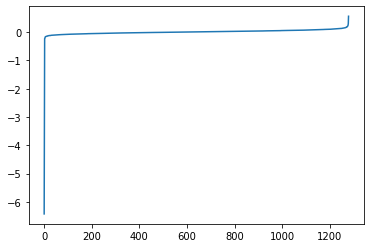

In [172]:
wt.iloc[1,:].sort_values().reset_index(drop=True).plot.line();

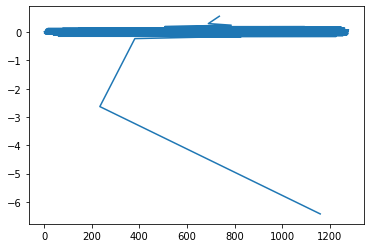

In [168]:
wt.iloc[1,:].sort_values().plot.line();

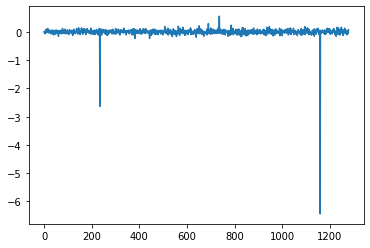

In [166]:
mutant.iloc[1,:].plot.line();

In [143]:
difference = (wt-mutant)*100

In [146]:
difference.sum(axis=1)

0       0.320376
1       0.481710
2       0.312745
3      -0.172836
4       0.414252
          ...   
6586    0.675470
6587    1.490860
6588   -4.357233
6589   -2.425898
6590   -2.844078
Length: 6591, dtype: float32

In [147]:
df_combine['difference'] = difference.sum(axis=1)

In [152]:
sub = df_combine.query('split == "test"')[['seq_id','difference']]

In [154]:
sub.reset_index(inplace=True,drop=True)

In [158]:
sub.rename(columns ={'difference':'tm'}, inplace=True)

In [160]:
sub.to_csv('submission.csv', index=False)

In [161]:
len(sub)

2413